In [ ]:
# stage 1 training and prediction
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import ta
import joblib
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import random
import os
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
os.environ['PYTHONHASHSEED'] = str(GLOBAL_SEED)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
# ------------------------------------------------------------------------
# 0. Load and align data
# ------------------------------------------------------------------------
factors = pd.read_csv("aligned_factors.csv", index_col=0, parse_dates=True)
returns = pd.read_csv("daily_returns_10ETFs.csv", index_col=0, parse_dates=True)

# Align dates to ensure matching indices
dates = factors.index.intersection(returns.index)
factors = factors.loc[dates]
returns = returns.loc[dates]


# ------------------------------------------------------------------------
# 1. Compute technical indicators and lagged features per ETF
# ------------------------------------------------------------------------
all_tech_features = []

for etf in returns.columns:
    close = (1 + returns[etf]).cumprod()
    tech_df = pd.DataFrame(index=returns.index)

    # Selected indicators (others commented out to reduce noise)
    tech_df[f'{etf}_SMA_5']   = ta.trend.sma_indicator(close, window=5)
    tech_df[f'{etf}_EMA_12']  = ta.trend.ema_indicator(close, window=12)
    tech_df[f'{etf}_RSI_7']   = ta.momentum.rsi(close, window=7)
    tech_df[f'{etf}_MACD']    = ta.trend.macd_diff(close)
    tech_df[f'{etf}_ATR']     = ta.volatility.average_true_range(
        high=close * 1.01, low=close * 0.99, close=close, window=10
    )
    tech_df[f'{etf}_Vol_5']   = returns[etf].rolling(window=5).std()
    tech_df[f'{etf}_Mom_3']   = returns[etf].rolling(window=3).mean()

    # Lagged returns (shifted so only past information is used)
    for lag in [1, 2, 3]:
        tech_df[f'{etf}_LagRet_{lag}'] = returns[etf].shift(lag)

    all_tech_features.append(tech_df)

# Concatenate technical indicators for all ETFs
technical_features = pd.concat(all_tech_features, axis=1)

# ------------------------------------------------------------------------
# 2. Create lagged factor features
# ------------------------------------------------------------------------
for factor in ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']:
    for lag in [1, 2, 3]:
        factors[f'{factor}_lag_{lag}'] = factors[factor].shift(lag)

# Drop rows with NA values arising from lagging
factors = factors.dropna()

# ------------------------------------------------------------------------
# 3. Combine factors, technical features, and VIX change
# ------------------------------------------------------------------------
features = pd.concat([factors, technical_features], axis=1).dropna()
vix = pd.read_csv("VIX_History.csv", index_col=0, parse_dates=True)

# Align VIX to our feature dates and compute lagged change
vix_aligned = vix['CLOSE'].reindex(features.index).ffill()
features['VIX'] = vix_aligned.pct_change(fill_method=None).shift(1)
features['VIX'] = features['VIX'].fillna(0)

# Define the target: next-day return per ETF
target_returns = returns.shift(-1).loc[features.index].dropna()
features = features.loc[target_returns.index]

# ------------------------------------------------------------------------
# 4. Define rolling window parameters
# ------------------------------------------------------------------------
train_years = 12      # years used for training
valid_years = 1       # years used for validation
test_years  = 1       # years used for testing/prediction
retrain_frequency = 1 # years between retrainings
start_year = 2009
end_year   = 2024

# List generic features used for SHAP importance ranking
all_generic_features = [
    'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA',
    'Mkt-RF_lag_1', 'Mkt-RF_lag_2', 'Mkt-RF_lag_3',
    'SMB_lag_1', 'SMB_lag_2', 'SMB_lag_3',
    'HML_lag_1', 'HML_lag_2', 'HML_lag_3',
    'RMW_lag_1', 'RMW_lag_2', 'RMW_lag_3',
    'CMA_lag_1', 'CMA_lag_2', 'CMA_lag_3',
    'SMA_5', 'EMA_12', 'RSI_7', 'MACD',
    'Vol_5', 'Mom_3',
    'LagRet_1', 'LagRet_2', 'LagRet_3', 'VIX'
]

# ------------------------------------------------------------------------
# 5. Compute generic feature importance via SHAP
#    (aggregated across ETFs, using only the initial training window)
# ------------------------------------------------------------------------
shap_importances = pd.DataFrame(0.0, index=all_generic_features, columns=['SHAP_Value'])

# Use a fixed period (e.g. up to year 2009) for computing importances
base_train_start = pd.Timestamp(start_year - train_years, 1, 1)
base_train_end   = pd.Timestamp(start_year - valid_years - 1, 12, 31)

for etf in returns.columns:
    print(f"Computing SHAP importances for ETF: {etf}")
    # Filter columns relevant to this ETF (generic + factor features)
    etf_cols = [
        col for col in features.columns
        if (etf in col and any(k in col for k in ['SMA_5', 'EMA_12', 'RSI_7',
                                                  'MACD', 'Vol_5', 'Mom_3',
                                                  'LagRet_1','LagRet_2','LagRet_3', 'VIX']))
        or col in ['Mkt-RF','SMB','HML','RMW','CMA',
                   'Mkt-RF_lag_1','Mkt-RF_lag_2','Mkt-RF_lag_3',
                   'SMB_lag_1','SMB_lag_2','SMB_lag_3',
                   'HML_lag_1','HML_lag_2','HML_lag_3',
                   'RMW_lag_1','RMW_lag_2','RMW_lag_3',
                   'CMA_lag_1','CMA_lag_2','CMA_lag_3']
    ]
    X_base  = features.loc[base_train_start:base_train_end, etf_cols]
    y_base  = target_returns[etf].loc[base_train_start:base_train_end]

    # Fit a quick model to compute SHAP
    model_base = xgb.XGBRegressor(
        objective='reg:squarederror',
        tree_method='hist',
        random_state=GLOBAL_SEED,
        seed=GLOBAL_SEED,
        device='cuda'
    ).fit(X_base, y_base)

    explainer_base = shap.Explainer(model_base)
    shap_vals = explainer_base(X_base)

    # Aggregate SHAP values per generic feature
    for gen_feat in all_generic_features:
        cols = [c for c in X_base.columns if gen_feat in c]
        if cols:
            idx = [X_base.columns.get_loc(c) for c in cols]
            shap_importances.loc[gen_feat] += np.mean(np.abs(shap_vals.values[:, idx]))

# Average importance across ETFs and select top N
shap_importances /= len(returns.columns)
top_generic_features = (
    shap_importances.sort_values('SHAP_Value', ascending=False)
                    .head(10)
                    .index
                    .tolist()
)

# returns = returns.iloc[:,:2]
# ------------------------------------------------------------------------
# 6. Retrain models using the selected generic features in rolling windows
# ------------------------------------------------------------------------
all_predictions = []

# for etf in returns.columns:
#     print(f"\n==== Training models for ETF: {etf} ====")
#     # Select columns containing any of the top_generic_features or factor names
#     selected_features = [
#         f for f in features.columns
#         if any(gen in f for gen in top_generic_features) or f in factors.columns
#     ]

for etf in returns.columns:
    print(f"\n==== Training models for ETF: {etf} ====")

    # Select features explicitly relevant to current ETF
    # selected_features = [
    #     f for f in features.columns
    #     if (
    #         # Include ETF-specific technical indicators explicitly
    #         (any(gen in f for gen in top_generic_features) and (etf in f))
    #         # Include ONLY explicitly selected generic FF factors or their lags
    #         or (any(gen == f for gen in top_generic_features))
    #     )
    # ]

    selected_features = []

    for feature in top_generic_features:
        # Clearly check if the feature is ETF-specific (technical indicators)
        etf_specific_feature_name = f'{etf}_{feature}'

        # Add ETF-specific feature explicitly if present in columns
        if etf_specific_feature_name in features.columns:
            selected_features.append(etf_specific_feature_name)

        # If not ETF-specific, explicitly add generic factor features directly
        elif feature in features.columns:
            selected_features.append(feature)

    # Sanity check to ensure you have valid selected features
    if not selected_features:
        raise ValueError(f"No features selected for {etf}, please verify feature names.")

    print(f"Selected features for {etf}: {selected_features}")

    year = start_year
    while year <= end_year - test_years + 1:
        print(f"\nTraining window starting {year}")
        start_time = time.time()

        # Define periods
        train_start = pd.Timestamp(year - train_years, 1, 1)
        train_end   = pd.Timestamp(year - valid_years - 1, 12, 31)
        valid_start = pd.Timestamp(year - valid_years, 1, 1)
        valid_end   = pd.Timestamp(year - 1, 12, 31)
        test_start  = pd.Timestamp(year, 1, 1)
        test_end    = pd.Timestamp(year + test_years - 1, 12, 31)

        # Extract data
        X_train = features.loc[train_start:train_end, selected_features]
        y_train = target_returns[etf].loc[train_start:train_end]
        X_valid = features.loc[valid_start:valid_end, selected_features]
        y_valid = target_returns[etf].loc[valid_start:valid_end]
        X_test  = features.loc[test_start:test_end, selected_features]
        y_test  = target_returns[etf].loc[test_start:test_end]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_valid_scaled = scaler.transform(X_valid)
        X_test_scaled = scaler.transform(X_test)

        # # Base model with early stopping
        # base_model = xgb.XGBRegressor(
        #     objective='reg:squarederror',
        #     tree_method='hist',
        #     device='cuda',
        #     random_state=42,
        #     n_jobs=4,
        #     # eval_metric='rmse', # The metric to monitor for early stopping
        #     # early_stopping_rounds=50
        # )
        # 
        # param_grid = {
        #     'n_estimators': [200, 400],
        #     'max_depth': [3, 4, 5],
        #     'learning_rate': [0.03, 0.05],
        #     'subsample': [0.7, 0.8],
        #     'colsample_bytree': [0.7, 0.8]
        # }
        # 
        # tscv = TimeSeriesSplit(n_splits=3)
        # 
        # grid_search = GridSearchCV(
        #     base_model,
        #     param_grid,
        #     cv=tscv,
        #     scoring='neg_mean_squared_error',
        #     verbose=0,
        #     n_jobs=4
        # )
        # 
        # # Fit with early stopping on the explicit validation set
        # # fit_params = {
        # #     "eval_set": [(X_valid, y_valid)],
        # #     "verbose": False
        # # }
        # # 
        # # # grid_search.fit(X_train, y_train, **fit_params)
        # # grid_search.fit(X_train_scaled, y_train)
        # 
        # fit_params = {
        #     'eval_set': [(X_valid_scaled, y_valid)],
        #     'eval_metric': 'rmse',
        #     'early_stopping_rounds': 50,
        #     'verbose': False
        # }
        # 
        # grid_search.fit(X_train_scaled, y_train, **fit_params)
        # 
        # best_model = grid_search.best_estimator_
        # 
        # # Predict on the test period
        # preds = best_model.predict(X_test_scaled)


        # Define your parameter grid explicitly
        param_grid = {
            'n_estimators': [200, 400],
            'max_depth': [3, 4, 5],
            'learning_rate': [0.03, 0.05],
            'subsample': [0.7, 0.8],
            'colsample_bytree': [0.7, 0.8]
        }

        tscv = TimeSeriesSplit(n_splits=3)

        best_score = float('inf')
        best_params = None
        best_model = None

        # Explicit loop for parameter search and cross-validation
        for params in ParameterGrid(param_grid):
            cv_rmse = []

            for train_idx, val_idx in tscv.split(X_train_scaled):
                X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
                y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                # DMatrix explicitly required by XGBoost native API
                dtrain = xgb.DMatrix(X_fold_train, label=y_fold_train)
                dval = xgb.DMatrix(X_fold_val, label=y_fold_val)

                # Setup watchlist explicitly for early stopping
                watchlist = [(dtrain, 'train'), (dval, 'validation')]

                xgb_params = {
                    'objective': 'reg:squarederror',
                    'tree_method': 'hist',
                    'device': 'cuda',
                    'eval_metric': 'rmse',
                    'seed': 42,
                    'max_depth': params['max_depth'],
                    'learning_rate': params['learning_rate'],
                    'subsample': params['subsample'],
                    'colsample_bytree': params['colsample_bytree']
                }

                # Explicitly train with early stopping
                model = xgb.train(
                    xgb_params,
                    dtrain,
                    num_boost_round=params['n_estimators'],
                    evals=watchlist,
                    early_stopping_rounds=50,
                    verbose_eval=False
                )

                preds = model.predict(dval)
                rmse = np.sqrt(mean_squared_error(y_fold_val, preds))
                cv_rmse.append(rmse)

            avg_rmse = np.mean(cv_rmse)
            # print(f"Params: {params}, CV Avg RMSE: {avg_rmse:.6f}")

            if avg_rmse < best_score:
                best_score = avg_rmse
                best_params = params
                best_model = model

        # Train final model explicitly with best parameters on full training data
        dtrain_full = xgb.DMatrix(X_train_scaled, label=y_train)
        dvalid_full = xgb.DMatrix(X_valid_scaled, label=y_valid)

        watchlist_full = [(dtrain_full, 'train'), (dvalid_full, 'validation')]

        final_xgb_params = {
            'objective': 'reg:squarederror',
            'tree_method': 'hist',
            'device': 'cuda',
            'eval_metric': 'rmse',
            'seed': 42,
            'max_depth': best_params['max_depth'],
            'learning_rate': best_params['learning_rate'],
            'subsample': best_params['subsample'],
            'colsample_bytree': best_params['colsample_bytree']
        }

        best_model = xgb.train(
            final_xgb_params,
            dtrain_full,
            num_boost_round=best_params['n_estimators'],
            evals=watchlist_full,
            early_stopping_rounds=50,
            verbose_eval=False
        )

        # Predict explicitly on test data
        dtest = xgb.DMatrix(X_test_scaled)
        preds = best_model.predict(dtest)

        # Metrics clearly
        test_rmse = np.sqrt(mean_squared_error(y_test, preds))
        # print(f"Test RMSE: {test_rmse:.6f}")

        # Compute evaluation metrics
        mse  = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        mae  = mean_absolute_error(y_test, preds)
        r2   = r2_score(y_test, preds)
        dir_acc = np.mean((np.sign(y_test) == np.sign(preds)).astype(int))

        print(f"MSE: {mse:.6f}  RMSE: {rmse:.6f}  MAE: {mae:.6f}  "
              f"R²: {r2:.6f}  DirAcc: {dir_acc:.2%}")

        # Save the model for reproducibility
        joblib.dump(best_model, f"best_model_{etf}_{year}.joblib")

        # Save predictions
        preds_df = pd.DataFrame({
            'Date': X_test.index,
            'ETF': etf,
            'Year': year,
            'Actual_Return': y_test,
            'Predicted_Return': preds
        }).reset_index(drop=True)

        # Compute SHAP values on the test set
        explainer_test = shap.Explainer(best_model, feature_names=X_test.columns)
        shap_vals_test = explainer_test(X_test_scaled)

        clean_shap_cols = [
            f'SHAP_{col.replace(f"{etf}_", "")}' if col.startswith(f'{etf}_') else f'SHAP_{col}'
            for col in X_test.columns
        ]

        shap_df = pd.DataFrame(
            shap_vals_test.values,
            columns=clean_shap_cols,
            # columns=[f'SHAP_{col}' for col in X_test.columns],
            index=X_test.index
        ).reset_index().rename(columns={'index': 'Date'})

        # Merge SHAP values with predictions
        preds_df = preds_df.merge(shap_df, on='Date', how='left')

        all_predictions.append(preds_df)

        # Advance the window
        year += retrain_frequency
        print(f"Window processed in {time.time() - start_time:.2f} seconds")

# Concatenate and save all predictions and SHAP values
final_predictions_df = pd.concat(all_predictions, ignore_index=True)
final_predictions_df.to_csv("stage1_predictions_with_shap_10ETFs.csv", index=False)

print("Stage 1 completed and data saved for Stage 2.")


In [ ]:
returns

In [ ]:
best_params

In [ ]:
top_generic_features

In [ ]:
import pandas as pd
import numpy as np
import json

# Load stage 1 predictions with SHAP values explicitly
stage1_df = pd.read_csv("stage1_predictions_with_shap_10ETFs.csv", parse_dates=['Date'])
etfs = stage1_df['ETF'].unique()

# Initialize DataFrame explicitly for aggregated daily data
dates = sorted(stage1_df['Date'].unique())
aggregated_data = pd.DataFrame({'Date': dates})

# Pivot tables for efficient cross-sectional computations
predicted_returns = stage1_df.pivot(index='Date', columns='ETF', values='Predicted_Return')
actual_returns = stage1_df.pivot(index='Date', columns='ETF', values='Actual_Return')

# Compute ETF-specific volatility (rolling 5-day window)
volatility = actual_returns.rolling(window=5).std()

# Merge explicitly into aggregated_data
for etf in etfs:
    aggregated_data[f'Predicted_Return_{etf}'] = aggregated_data['Date'].map(predicted_returns[etf])
    aggregated_data[f'Actual_Return_{etf}'] = aggregated_data['Date'].map(actual_returns[etf])
    aggregated_data[f'Volatility_{etf}'] = aggregated_data['Date'].map(volatility[etf])

# Dynamically load the top generic features from Stage 1 explicitly to maintain consistency
# generic_shap_features = ['LagRet_1',
#  'HML_lag_2',
#  'LagRet_2',
#  'Vol_5',
#  'Mom_3',
#  'LagRet_3',
#  'SMB_lag_2',
#  'MACD',
#  'Mkt-RF',
#  'HML']
generic_shap_features = top_generic_features

# Aggregate SHAP values (mean and std across ETFs) explicitly by generic feature
shap_aggregated_features = {}

for feature in generic_shap_features:
    matching_cols = [col for col in stage1_df.columns 
                     if col.startswith('SHAP_') and col.endswith(feature)]

    if matching_cols:
        shap_means = stage1_df.groupby('Date')[matching_cols].mean().mean(axis=1)
        shap_stds = stage1_df.groupby('Date')[matching_cols].std().mean(axis=1)

        shap_aggregated_features[f'Avg_SHAP_{feature}'] = shap_means
        shap_aggregated_features[f'Std_SHAP_{feature}'] = shap_stds
    else:
        print(f"Warning: No matches found for SHAP feature: {feature}")

# Convert aggregated SHAP features explicitly to DataFrame
shap_aggregated_df = pd.DataFrame(shap_aggregated_features).reset_index()

# Merge aggregated SHAP features explicitly
aggregated_data = pd.merge(aggregated_data, shap_aggregated_df, on='Date', how='left')

# Explicitly compute additional cross-sectional signals for richer Stage 2 observations
# Cross-sectional mean and std of predicted returns
aggregated_data['CrossSec_Mean_PredRet'] = predicted_returns.mean(axis=1).values
aggregated_data['CrossSec_Std_PredRet'] = predicted_returns.std(axis=1).values

# Cross-sectional mean volatility
aggregated_data['CrossSec_Mean_Volatility'] = volatility.mean(axis=1).values

# Rank ETFs by predicted return explicitly (percentile ranks)
ranked_preds = predicted_returns.rank(axis=1, pct=True)
for etf in etfs:
    aggregated_data[f'Rank_PredRet_{etf}'] = aggregated_data['Date'].map(ranked_preds[etf])

# Handle missing values explicitly and robustly:
# Forward-fill only SHAP and cross-sectional features explicitly
shap_and_crosssec_cols = [col for col in aggregated_data.columns if 'SHAP' in col or 'CrossSec' in col]
aggregated_data[shap_and_crosssec_cols] = aggregated_data[shap_and_crosssec_cols].ffill()

# Drop rows explicitly where ETF volatility calculations have initial NaNs
vol_cols = [f'Volatility_{etf}' for etf in etfs]
aggregated_data.dropna(subset=vol_cols, inplace=True)

# Final sanity checks explicitly for data quality assurance
if aggregated_data.empty:
    raise ValueError("Aggregated dataset is empty after preprocessing. Verify your input data.")
else:
    # Quick summary statistics explicitly for diagnostics
    print("Aggregated DataFrame shape:", aggregated_data.shape)
    print("Aggregated DataFrame summary stats:")
    print(aggregated_data.describe().transpose())

    # Save optimized data explicitly for Stage 2
    aggregated_data.to_csv("stage2_rl_observations_optimized_10ETFs.csv", index=False)
    print("Optimized Stage 2 RL dataset successfully saved.")


In [ ]:
import pandas as pd
import glob
import os

# Configuration
output_dir = 'stage2_iterations'  # Adjust if your path is different
pattern = os.path.join(output_dir, 'iteration_*', 'window_*', 'weights.csv')

# Find all weight files matching the pattern
files = glob.glob(pattern)

# Initialize an empty list to collect DataFrames
all_weights = []

for file_path in files:
    # Extract iteration and window numbers
    parts = file_path.split(os.sep)
    iteration = int(parts[-3].split('_')[1])
    window = int(parts[-2].split('_')[1])

    # Load weights file
    df = pd.read_csv(file_path, parse_dates=['Date'])

    # Add columns for iteration and window
    df.insert(0, 'Window', window)
    df.insert(0, 'Iteration', iteration)

    # Append to the list
    all_weights.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(all_weights, ignore_index=True)

# Sort by iteration, window, and date
combined_df.sort_values(['Iteration', 'Window', 'Date'], inplace=True)

# Save combined data
combined_df.to_csv(os.path.join(output_dir, 'combined_weights.csv'), index=False)

print(f"Combined weights saved to: {os.path.join(output_dir, 'combined_weights.csv')}")


In [3]:
# import numpy as np
# import pandas as pd
# from scipy.stats import spearmanr
# import matplotlib.pyplot as plt
# 
# def _monthly_agg(series, method="compound"):
#     """Aggregate a daily return series to monthly."""
#     s = series.dropna()
#     if s.empty: 
#         return np.nan
#     if method == "sum":
#         return s.sum()                 # good if returns are already small daily
#     elif method == "compound":
#         return float(np.prod(1.0 + s.values) - 1.0)  # exact
#     else:
#         raise ValueError("method must be 'sum' or 'compound'")
# 
# def monthly_ic(feature_df: pd.DataFrame,
#                etf_list: list,
#                pred_prefix: str = "Predicted_Return_",
#                actual_prefix: str = "Actual_Return_",
#                agg_method: str = "compound",
#                shift_horizon: int = 1,
#                make_plots: bool = True) -> pd.DataFrame:
#     """
#     Computes cross-sectional monthly Spearman IC between Stage-1 predictions and FUTURE realized returns.
# 
#     Parameters
#     ----------
#     feature_df : DataFrame
#         Must contain 'Date', columns Predicted_Return_{ETF}, Actual_Return_{ETF}.
#         Daily frequency (or higher), one row per day.
#     etf_list : list[str]
#         Universe tickers matching the suffix in column names.
#     pred_prefix, actual_prefix : str
#         Column prefixes to find predicted and actual returns.
#     agg_method : 'compound' or 'sum'
#         How to get monthly realized returns from daily.
#     shift_horizon : int
#         How many months ahead to align realized returns for IC.
#         1 = next month (recommended). 0 = same month (leakage risk).
#     make_plots : bool
#         If True, shows time series + histogram.
# 
#     Returns
#     -------
#     ic_df : DataFrame with columns [Month, IC, N]
#     """
#     df = feature_df.copy()
#     df = df.sort_values("Date").reset_index(drop=True)
#     if "Date" not in df.columns:
#         raise ValueError("feature_df must contain a 'Date' column")
#     df["Month"] = df["Date"].dt.to_period("M")
# 
#     pred_cols = [f"{pred_prefix}{e}" for e in etf_list]
#     act_cols  = [f"{actual_prefix}{e}" for e in etf_list]
#     missing = [c for c in pred_cols + act_cols if c not in df.columns]
#     if missing:
#         raise ValueError(f"Missing columns: {missing}")
# 
#     # (A) Aggregate PREDICTIONS per month cross-sectionally: use the **mean prediction** within month
#     #     You could also take the last day of the month if that’s how you trade.
#     pred_m = (df.groupby("Month")[pred_cols]
#                 .mean()
#                 .dropna(how="all"))
# 
#     # (B) Aggregate ACTUAL returns per month per ETF via chosen method
#     #     (sum is okay; compound is exact)
#     pieces = []
#     for m, g in df.groupby("Month"):
#         monthly = {}
#         for e in etf_list:
#             monthly[f"{actual_prefix}{e}"] = _monthly_agg(g[f"{actual_prefix}{e}"], agg_method)
#         s = pd.Series(monthly, name=m)
#         pieces.append(s)
#     act_m = pd.DataFrame(pieces)
#     act_m.index.name = "Month"
# 
#     # Align, and **shift realized returns forward** (so month t predictions are evaluated vs month t+1 returns)
#     common = pred_m.index.intersection(act_m.index)
#     pred_m = pred_m.loc[common]
#     act_m = act_m.loc[common]
# 
#     if shift_horizon != 0:
#         act_m = act_m.shift(-shift_horizon)
# 
#     # Drop last row if it became NaN after shift
#     aligned = pred_m.join(act_m, how="inner")
#     aligned = aligned.dropna(how="any")
# 
#     rows = []
#     for m, row in aligned.iterrows():
#         preds = np.array([row[f"{pred_prefix}{e}"] for e in etf_list], dtype=float)
#         rets  = np.array([row[f"{actual_prefix}{e}"] for e in etf_list], dtype=float)
#         mask = np.isfinite(preds) & np.isfinite(rets)
#         if mask.sum() >= max(3, int(0.6 * len(etf_list))):  # need enough names
#             ic, _ = spearmanr(preds[mask], rets[mask])
#             rows.append({"Month": m.to_timestamp(), "IC": float(ic), "N": int(mask.sum())})
#         else:
#             rows.append({"Month": m.to_timestamp(), "IC": np.nan, "N": int(mask.sum())})
# 
#     ic_df = pd.DataFrame(rows).sort_values("Month")
#     if ic_df.empty:
#         print("No monthly ICs computed (check inputs).")
#         return ic_df
# 
#     mean_ic = ic_df["IC"].mean(skipna=True)
#     med_ic  = ic_df["IC"].median(skipna=True)
#     pos_frac = (ic_df["IC"] > 0).mean()
# 
#     print(f"Monthly IC (horizon=+{shift_horizon}): mean={mean_ic:.3f}, median={med_ic:.3f}, "
#           f"%>0={pos_frac:.1%}, Nmonths={ic_df['IC'].notna().sum()}")
# 
#     if make_plots:
#         plt.figure(figsize=(9, 3))
#         plt.plot(ic_df["Month"], ic_df["IC"], lw=1)
#         plt.axhline(0, color="k", ls="--", lw=1)
#         plt.title("Monthly Spearman IC (Pred vs next-month realized)")
#         plt.ylabel("IC")
#         plt.xlabel("Month")
#         plt.tight_layout()
#         plt.show()
# 
#         plt.figure(figsize=(5, 3))
#         ic_df["IC"].hist(bins=21)
#         plt.axvline(ic_df["IC"].mean(), color="r", lw=1, label="mean")
#         plt.title("IC distribution")
#         plt.legend()
#         plt.tight_layout()
#         plt.show()
# 
#     return ic_df


Monthly IC (horizon=+1): mean=0.060, median=0.100, %>0=56.1%, Nmonths=189


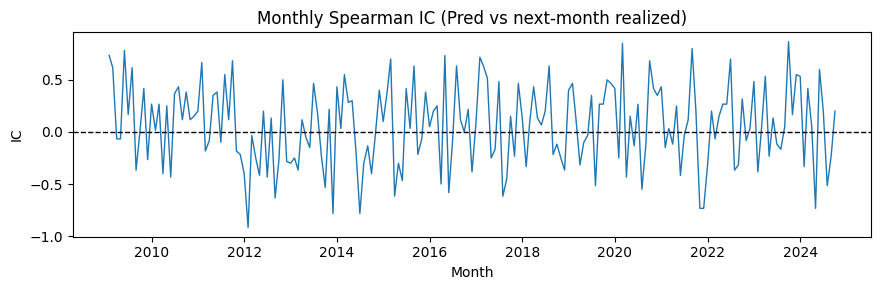

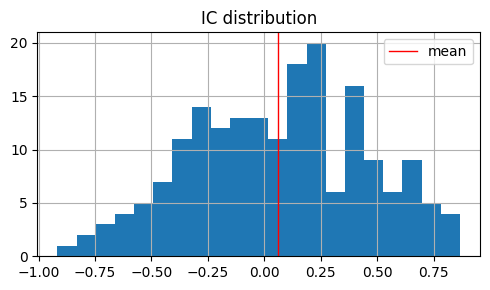

In [5]:
# # etf_list inferred earlier; or define explicitly
# data = pd.read_csv("stage2_rl_observations_optimized_10ETFs.csv", parse_dates=["Date"])
# price_data = pd.read_csv("stock_prices_10ETFs.csv")
# price_data["Date"] = pd.to_datetime(price_data["Date"], utc=True).dt.tz_localize(None)
# price_cols = {col: f"Price_{col}" for col in price_data.columns if col != "Date"}
# price_data.rename(columns=price_cols, inplace=True)
# 
# merged = pd.merge(data, price_data, on="Date", how="inner").reset_index(drop=True)
# if len(merged) != len(data):
#     print("Warning: data length mismatch after merge.")
# 
# # Universe: infer from Actual_Return_* columns (safer than hand-typing)
# etf_list = infer_etf_list(merged)
# 
# # Add stable (return-based) features and optional filters
# feature_data = add_stable_features(merged, etf_list)
# feature_data = filter_features(feature_data, include_predicted_returns=True, include_shap_metrics=True)
# 
# # Impute/scale FEATURES ONLY
# feature_cols = [c for c in feature_data.columns if c != "Date" and not c.startswith("Actual_Return_")]
# ret_cols = [c for c in feature_data.columns if c.startswith("Actual_Return_")]
# 
# # Forward/backward fill only features
# feature_data[feature_cols] = feature_data[feature_cols].ffill().bfill()
# # Drop any rows with missing realized returns
# feature_data.dropna(subset=ret_cols, inplace=True)
# ic_df = monthly_ic(
#     feature_df=feature_data,
#     etf_list=etf_list,
#     pred_prefix="Predicted_Return_",
#     actual_prefix="Actual_Return_",
#     agg_method="compound",   # or "sum"
#     shift_horizon=1,         # next-month
#     make_plots=True
# )


LS mean=-0.0002, vol=0.0548, Sharpe=-0.01


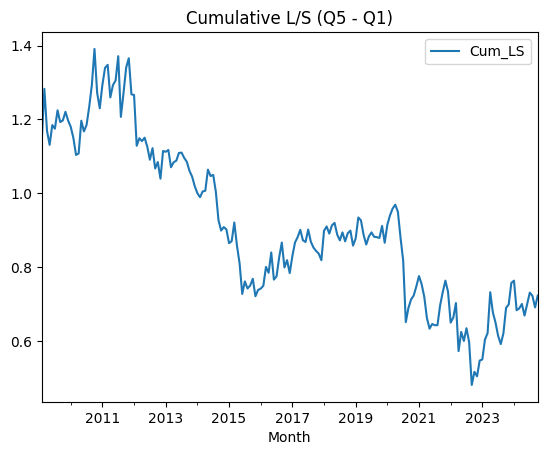

In [7]:
# def longshort_quintiles(feature_df, etf_list,
#                         pred_prefix="Predicted_Return_", actual_prefix="Actual_Return_",
#                         agg_method="compound", shift_horizon=1):
#     df = feature_df.copy().sort_values("Date").reset_index(drop=True)
#     df["Month"] = df["Date"].dt.to_period("M")
# 
#     # monthly predictions: last day of month is common in practice
#     pred_m = df.groupby("Month")[[f"{pred_prefix}{e}" for e in etf_list]].last()
# 
#     # monthly realized returns
#     pieces = []
#     for m, g in df.groupby("Month"):
#         monthly = {}
#         for e in etf_list:
#             monthly[e] = _monthly_agg(g[f"{actual_prefix}{e}"], agg_method)
#         pieces.append(pd.Series(monthly, name=m))
#     act_m = pd.DataFrame(pieces)
# 
#     # shift realized returns to next month
#     act_m = act_m.shift(-shift_horizon)
# 
#     aligned = pred_m.join(act_m, how="inner", lsuffix="_pred", rsuffix="_ret").dropna(how="any")
#     if aligned.empty:
#         print("No data after alignment.")
#         return None
# 
#     ls_rets, q1_rets, q5_rets = [], [], []
#     for m, row in aligned.iterrows():
#         preds = row[[f"{pred_prefix}{e}" for e in etf_list]].values
#         rets  = row[etf_list].values
#         if not (np.isfinite(preds).all() and np.isfinite(rets).all()):
#             continue
#         ranks = preds.argsort()  # ascending
#         q = len(etf_list) // 5
#         lo_idx = ranks[:q]
#         hi_idx = ranks[-q:]
#         q1_rets.append(np.mean(rets[lo_idx]))
#         q5_rets.append(np.mean(rets[hi_idx]))
#         ls_rets.append(np.mean(rets[hi_idx]) - np.mean(rets[lo_idx]))
# 
#     res = pd.DataFrame({
#         "Month": [p.to_timestamp() for p in aligned.index],
#         "Q5_Long": q5_rets,
#         "Q1_Short": q1_rets,
#         "Q5_minus_Q1": ls_rets
#     })
#     res["Cum_LS"] = (1 + res["Q5_minus_Q1"]).cumprod()
# 
#     print(f"LS mean={res['Q5_minus_Q1'].mean():.4f}, "
#           f"vol={res['Q5_minus_Q1'].std(ddof=1):.4f}, "
#           f"Sharpe={res['Q5_minus_Q1'].mean()/res['Q5_minus_Q1'].std(ddof=1)*np.sqrt(12):.2f}")
# 
#     res.plot(x="Month", y="Cum_LS", title="Cumulative L/S (Q5 - Q1)")
#     plt.show()
#     return res
# 
# ls_df = longshort_quintiles(feature_data, etf_list)


In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from scipy.optimize import minimize

class PortfolioEnv(gym.Env):
    """
    Monthly Mean-CVaR portfolio environment.

    Reward (paid once per month at rebalance boundary):
        reward_t = month_ret_t  -  risk_coefficient * CVaR( monthly_ret_history )
                     - lambda_turnover * turnover_t
                     - lambda_hhi * HHI(weights_t)
                     - transaction_cost_rate * turnover_t

    Key behaviors:
    - Rebalance every `rebalance_period` days using action -> weights mapping
      that supports baseline-relative or delta-to-current semantics.
    - Between rebalances, weights drift self-financing.
    - Observations are a flat vector of the last `lookback_period` days of features.
    """

    metadata = {"render_modes": []}

    def __init__(
        self,
        data,
        etf_list,
        reward_type="mean_cvar",
        risk_coefficient=0.5,
        rebalance_period=21,
        lookback_period=21,
        weight_bounds=(0.0, 1.0),            # (min_weight, max_weight)
        desired_long=1.0,                    # total long budget (e.g., 1.2 for 120/20)
        desired_short=0.0,                   # total short budget (e.g., 0.2 for 120/20)
        use_baseline=False,
        baseline_fn=None,                    # fn(date) -> weight vector
        transaction_cost_rate=0.0,
        lambda_turnover=0.001,
        lambda_hhi=0.1,
        # Enhancements / numerics:
        alpha=0.05,                          # CVaR tail level
        cvar_warmup_months=12,               # months before CVaR kicks in
        exclude_price_levels=True,           # drop columns starting with "Price_"
        action_temperature=1.0,              # scale for tanh squashing
        daily_return_clip=None               # e.g., 0.5 to clip daily returns; None to disable
    ):
        super().__init__()

        # ---------- Data / config ----------
        self.data = data.reset_index(drop=True)
        self.etf_list = list(etf_list)
        self.reward_type = reward_type
        self.risk_coefficient = float(risk_coefficient)
        self.rebalance_period = int(rebalance_period)
        self.lookback_period = int(lookback_period)
        self.weight_bounds = tuple(weight_bounds)
        self.desired_long = float(desired_long)
        self.desired_short = float(desired_short)
        self.use_baseline = bool(use_baseline)
        self.baseline_fn = baseline_fn
        self.transaction_cost_rate = float(transaction_cost_rate)
        self.lambda_turnover = float(lambda_turnover)
        self.lambda_hhi = float(lambda_hhi)
        self.alpha = float(alpha)
        self.cvar_warmup_months = int(cvar_warmup_months)
        self.exclude_price_levels = bool(exclude_price_levels)
        self.action_temperature = float(action_temperature)
        self.daily_return_clip = daily_return_clip if daily_return_clip is None else float(daily_return_clip)
        self._opt_baseline_cache = {}
        self._date_to_idx = {d: i for i, d in enumerate(self.data["Date"])}

        # ---------- Validate required columns ----------
        for etf in self.etf_list:
            col = f"Actual_Return_{etf}"
            if col not in self.data.columns:
                raise ValueError(f"Missing required column '{col}' in data.")
        if "Date" not in self.data.columns:
            raise ValueError("Data must contain a 'Date' column.")

        # ---------- Observation features ----------
        # Exclude date & realized returns; optionally exclude raw prices
        def keep_feature(c: str) -> bool:
            if c == "Date" or c.startswith("Actual_Return_"):
                return False
            if self.exclude_price_levels and c.startswith("Price_"):
                return False
            return True

        self.feature_cols = [c for c in self.data.columns if keep_feature(c)]
        self.num_features_per_day = len(self.feature_cols)

        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(len(self.etf_list),), dtype=np.float32
        )
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(self.num_features_per_day * self.lookback_period,),
            dtype=np.float32
        )

        # ---------- State ----------
        self.current_step = self.lookback_period
        self.cumulative_wealth = 1.0
        self.current_weights = np.ones(len(self.etf_list)) / len(self.etf_list)

        # Monthly bookkeeping
        self.daily_port_ret_buffer = []   # daily portfolio returns in current month
        self.monthly_ret_history = []     # realized monthly returns
        self._last_turnover = 0.0

    # ------------------------ Helpers ------------------------

    def _get_obs(self):
        start = self.current_step - self.lookback_period
        end = self.current_step
        obs_window = self.data.iloc[start:end]
        obs_values = obs_window[self.feature_cols].to_numpy(dtype=np.float32).reshape(-1)
        if not np.all(np.isfinite(obs_values)):
            obs_values = np.nan_to_num(obs_values, nan=0.0, posinf=0.0, neginf=0.0)
        return obs_values

    def _self_financing_drift(self, returns_today: np.ndarray) -> None:
        """Update weights passively between rebalances (long/short compatible)."""
        gross = self.current_weights * (1.0 + returns_today)
        denom = 1.0 + float(np.dot(self.current_weights, returns_today))
        self.current_weights = gross / max(denom, 1e-12)

    # def _baseline_weights(self, date):
    #     """Fetch and sanitize baseline weights (non-negative & normalized)."""
    #     if self.baseline_fn is None:
    #         return np.ones(len(self.etf_list)) / len(self.etf_list)
    #     w = np.asarray(self.baseline_fn(date), dtype=float)
    #     if not np.all(np.isfinite(w)) or w.shape[0] != len(self.etf_list):
    #         w = np.ones(len(self.etf_list)) / len(self.etf_list)
    #     # For safety, clip negatives and renormalize baseline
    #     w = np.clip(w, 0.0, None)
    #     s = w.sum()
    #     return w / s if s > 0 else np.ones(len(self.etf_list)) / len(self.etf_list)
    
    def _baseline_weights(self, date):
        """
        Baseline = Mean−CVaR (alpha=0.05) optimizer over past 252 trading days,
        using monthly compounding over 'rebalance_period' day windows.
        Long-only, fully-invested. Cached by date for speed.
    
        Falls back to equal-weight if not enough history or solver fails.
        """
        # If caller provided an external baseline_fn, honor that first.
        if callable(self.baseline_fn):
            w = np.asarray(self.baseline_fn(date), dtype=float)
            if not np.all(np.isfinite(w)) or w.shape[0] != len(self.etf_list):
                w = np.ones(len(self.etf_list)) / len(self.etf_list)
            w = np.clip(w, 0.0, None)
            s = w.sum()
            return w / s if s > 0 else np.ones(len(self.etf_list)) / len(self.etf_list)
    
        # Use cached result if we already solved this date.
        if hasattr(self, "_opt_baseline_cache") and date in self._opt_baseline_cache:
            return self._opt_baseline_cache[date].copy()
    
        # ------------------ Settings for this baseline ------------------
        lookback = 252
        horizon  = int(getattr(self, "rebalance_period", 21))  # monthly window length
        alpha    = 0.05                                        # CVaR tail
        lam_risk = float(getattr(self, "risk_coefficient", 0.5))  # same lambda used elsewhere
    
        # ------------------ Gather lookback returns ---------------------
        try:
            idx = self._date_to_idx[date]
        except Exception:
            # Fallback: locate by scan (slower but robust)
            idx = int(self.data.index[self.data["Date"] == date][0])
    
        # Need at least 252 days ending the day before 'date'
        if idx < lookback or horizon > lookback:
            w = np.ones(len(self.etf_list)) / len(self.etf_list)
            if hasattr(self, "_opt_baseline_cache"):
                self._opt_baseline_cache[date] = w
            return w.copy()
    
        cols = [f"Actual_Return_{etf}" for etf in self.etf_list]
        X = self.data.loc[idx - lookback: idx - 1, cols].to_numpy(dtype=float)   # [lookback, N]
        if not np.all(np.isfinite(X)):
            X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    
        # All rolling 'horizon' windows inside the lookback: shape [S, horizon, N]
        S = lookback - horizon + 1
        windows = np.stack([X[i:i + horizon, :] for i in range(S)], axis=0)
    
        # ------------------ Objective: mean − λ * CVaR ------------------
        def cvar_alpha(returns_1d: np.ndarray) -> float:
            m = returns_1d.shape[0]
            k = max(1, int(np.ceil(alpha * m)))
            worst = np.sort(returns_1d)[:k]
            return max(0.0, -float(np.mean(worst)))  # positive loss measure
    
        def objective(w: np.ndarray) -> float:
            # monthly compounded return for each scenario window
            daily = windows @ w                        # [S, horizon]
            month = np.prod(1.0 + daily, axis=1) - 1.0 # [S]
            mean_month = float(np.mean(month))
            loss_cvar  = cvar_alpha(month)
            # Maximize mean - lam_risk * CVaR  -> minimize negative
            return -(mean_month - lam_risk * loss_cvar)
    
        # ------------------ Solve (long-only, sum=1) --------------------
        n = len(self.etf_list)
        bounds = [(0.0, 1.0)] * n
        cons   = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}]
        initials = [np.ones(n)/n] + [np.random.dirichlet(np.ones(n)) for _ in range(2)]
    
        best_val, best_w = float("inf"), None
        for w0 in initials:
            res = minimize(objective, w0, method="SLSQP",
                           bounds=bounds, constraints=cons,
                           options={"maxiter": 160, "ftol": 1e-8})
            if res.success and res.fun < best_val:
                best_val, best_w = res.fun, res.x
    
        if best_w is None or not np.all(np.isfinite(best_w)):
            w = np.ones(n) / n
        else:
            w = np.clip(best_w, 0.0, None)
            s = w.sum()
            w = w / s if s > 0 else (np.ones(n) / n)
    
        # Cache and return
        if hasattr(self, "_opt_baseline_cache"):
            self._opt_baseline_cache[date] = w.copy()
        return w.copy()

    def _map_action_to_weights(self, action: np.ndarray, date) -> np.ndarray:
        """
        Map agent action to portfolio weights with long/short budgets and bounds.
        - Supports baseline-relative (if self.use_baseline) or delta-to-current.
        - Enforces desired long/short budgets after clipping to weight_bounds.
        """
        a = np.asarray(action, dtype=float)
        if not np.all(np.isfinite(a)):
            a = np.zeros_like(self.current_weights)

        # Smoothly squash actions to (-1, 1)
        temp = max(self.action_temperature, 1e-6)
        a = np.tanh(a / temp)

        if self.use_baseline:
            base = self._baseline_weights(date)
            raw = base * (1.0 + a)            # relative tilt around baseline
        else:
            raw = self.current_weights + a     # delta to current weights

        # Split long/short parts
        long_w = np.clip(raw, 0.0, None)
        short_w = np.clip(-raw, 0.0, None)

        has_long = long_w.sum() > 0
        has_short = short_w.sum() > 0
        n = len(raw)

        if has_long and has_short:
            norm_long = self.desired_long * long_w / long_w.sum()
            norm_short = self.desired_short * short_w / short_w.sum()
        elif has_long and not has_short:
            norm_long = long_w / long_w.sum()         # 100% long
            norm_short = np.zeros(n)
        elif not has_long and has_short:
            # Fallback: equal-weight long-only (avoid pathological all-short)
            norm_long = np.ones(n) / n
            norm_short = np.zeros(n)
        else:
            # All zeros -> equal-weight long-only
            norm_long = np.ones(n) / n
            norm_short = np.zeros(n)

        combined = norm_long - norm_short

        # Clip to hard bounds, then renormalize long/short budgets
        lo, hi = self.weight_bounds
        clipped = np.clip(combined, lo, hi)

        long_c = np.clip(clipped, 0.0, None)
        short_c = np.clip(-clipped, 0.0, None)

        if long_c.sum() > 0 and short_c.sum() > 0:
            final_long = self.desired_long * long_c / long_c.sum()
            final_short = self.desired_short * short_c / short_c.sum()
        elif long_c.sum() > 0:
            final_long = long_c / long_c.sum()
            final_short = np.zeros(n)
        else:
            final_long = np.ones(n) / n
            final_short = np.zeros(n)

        return final_long - final_short

    # ------------------------ Gym API ------------------------

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            np.random.seed(seed)
        self.current_step = self.lookback_period
        self.cumulative_wealth = 1.0
        self.current_weights = np.ones(len(self.etf_list)) / len(self.etf_list)
        self.daily_port_ret_buffer = []
        self.monthly_ret_history = []
        self._last_turnover = 0.0
        obs = self._get_obs()
        return obs, {}

    def step(self, action):
        next_step = self.current_step + 1
        reward = 0.0
        terminated = False

        # 1) Rebalance day: map action -> new weights, compute turnover
        if self.current_step % self.rebalance_period == 0:
            prev_w = self.current_weights.copy()
            current_date = self.data.loc[self.current_step, "Date"]
            new_w = self._map_action_to_weights(action, current_date)
            # L1 turnover
            self._last_turnover = float(np.sum(np.abs(new_w - prev_w)))
            self.current_weights = new_w

        # 2) Realize today's return (t -> t+1)
        if next_step >= len(self.data):
            # No next day to realize
            terminated = True
        else:
            asset_returns = np.array(
                [self.data.loc[next_step, f"Actual_Return_{etf}"] for etf in self.etf_list],
                dtype=float
            )
            # Optional daily return clipping (rarely needed if features are clean)
            port_ret = float(np.dot(self.current_weights, asset_returns))
            if self.daily_return_clip is not None:
                port_ret = float(np.clip(port_ret, -self.daily_return_clip, self.daily_return_clip))
            if not np.isfinite(port_ret):
                port_ret = 0.0

            self.cumulative_wealth *= (1.0 + port_ret)
            self.daily_port_ret_buffer.append(port_ret)

            # Passive drift on non-rebalance days
            if self.current_step % self.rebalance_period != 0:
                self._self_financing_drift(asset_returns)

            # 3) Pay monthly reward at boundary (or at the end)
            end_of_month = (next_step % self.rebalance_period == 0)
            last_step = (next_step == len(self.data) - 1)
            if end_of_month or last_step:
                month_ret = np.prod([1.0 + r for r in self.daily_port_ret_buffer]) - 1.0
                self.daily_port_ret_buffer = []

                # CVaR on time-series of monthly returns (excluding current month)
                cvar_loss = 0.0
                if len(self.monthly_ret_history) >= self.cvar_warmup_months:
                    arr = np.array(self.monthly_ret_history, dtype=float)
                    var = np.percentile(arr, 100.0 * self.alpha)
                    tail = arr[arr <= var]
                    if tail.size > 0:
                        cvar_loss = -float(np.mean(tail))  # positive loss

                # Base reward
                if self.reward_type == "mean_cvar":
                    base_reward = month_ret - self.risk_coefficient * cvar_loss
                elif self.reward_type == "cumulative_return":
                    base_reward = month_ret
                elif self.reward_type == "log_wealth":
                    base_reward = float(np.log(max(1.0 + month_ret, 1e-12)))
                elif self.reward_type == "mean_var":
                    # Not recommended here (monthly VAR of daily cross-sec isn't meaningful)
                    base_reward = month_ret
                else:
                    raise ValueError(f"Invalid reward type: {self.reward_type}")

                # Penalties and costs (once per month)
                hhi = float(np.sum(np.square(np.abs(self.current_weights))))
                penalty = self.lambda_hhi * hhi + self.lambda_turnover * self._last_turnover
                costs = self.transaction_cost_rate * self._last_turnover
                reward = base_reward - penalty - costs

                # Update monthly history AFTER computing reward
                self.monthly_ret_history.append(month_ret)

            terminated = next_step >= (len(self.data) - 1)

        self.current_step += 1
        obs = self._get_obs()
        if not np.all(np.isfinite(obs)):
            obs = np.nan_to_num(obs, nan=0.0, posinf=0.0, neginf=0.0)

        info = {
            "date": self.data.loc[min(self.current_step, len(self.data)-1), "Date"],
            "weights": self.current_weights.copy(),
            "cumulative_wealth": float(self.cumulative_wealth),
            "last_turnover": float(self._last_turnover),
            "num_months": len(self.monthly_ret_history),
        }
        return obs, float(reward), bool(terminated), False, info


In [4]:
# ===============================
# Stage 2 — Upgraded driver
# ===============================
import os
import json
import time
import gc
import random
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
from sklearn.model_selection import ParameterSampler
from sklearn.preprocessing import StandardScaler

import torch
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize
# Add once near imports
# ===== ADD: Monthly macro-step wrapper =====
import gymnasium as gym
import numpy as np

class MonthlyMacroWrapper(gym.Wrapper):
    """Each .step() advances a full month internally.
    The agent acts on the rebalance day; wrapper forwards zeros for the other days.
    """
    def __init__(self, env, rebalance_period: int):
        super().__init__(env)
        self.rebalance_period = int(rebalance_period)
        self._n = env.action_space.shape[0]

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

    def step(self, action):
        obs, reward, done, trunc, info = self.env.step(action)  # rebalance day
        for _ in range(self.rebalance_period - 1):
            if done:
                break
            zeros = np.zeros(self._n, dtype=np.float32)
            obs, r, done, trunc, info = self.env.step(zeros)
            reward += r  # monthly reward is non-zero on the last day
        return obs, reward, done, trunc, info


# ===== ADD: VecNormalize in-memory cloning (optional speed-up) =====
from copy import deepcopy
from stable_baselines3.common.vec_env import VecNormalize

def copy_vecnorm_stats(src, dst, use_vecnormalize: bool):
    """Copy normalization stats from src VecNormalize to dst (avoid disk I/O)."""
    if not use_vecnormalize:
        return
    if not (isinstance(src, VecNormalize) and isinstance(dst, VecNormalize)):
        return
    dst.obs_rms = deepcopy(src.obs_rms)
    dst.ret_rms = deepcopy(src.ret_rms)
    dst.clip_obs = src.clip_obs
    dst.clip_reward = src.clip_reward
    dst.gamma = src.gamma
    dst.training = False  # eval mode


# ===== ADD: Tilt baseline built from Stage-1 predicted returns =====
def make_tilt_baseline_fn(df: pd.DataFrame,
                          etf_list: List[str],
                          k_base: float = 10.0,            # softmax strength
                          vol_col_prefix: str = "Vol_20_",  # uses your stable features
                          use_inv_vol: bool = True,
                          ema_halflife_months: float = 3.0, # smoothing
                          floor: float = 0.02,              # min weight
                          cap: float = 0.22,                # max weight
                          dispersion_ref: float = 0.8) -> callable:
    """
    Returns baseline_fn(date) -> weights aligned to Date in df.
    Weights reflect cross-sectional tilts of Predicted_Return_* (optionally / vol),
    softmaxed to probabilities, smoothed via EMA, then clipped to [floor, cap].
    """
    pred_cols = [f"Predicted_Return_{e}" for e in etf_list]
    vol_cols  = [f"{vol_col_prefix}{e}"  for e in etf_list]

    dates = df["Date"].to_list()
    pred_mat = df[pred_cols].values
    if use_inv_vol:
        vol_mat = np.clip(df[vol_cols].values, 1e-6, None)
    else:
        vol_mat = np.ones_like(pred_mat)

    # per-asset floor/cap projection to sum to 1
    def _project_floor_cap(w, lo=floor, hi=cap):
        w = np.clip(w, lo, hi)
        s = w.sum()
        if s <= 0:
            w = np.ones_like(w) / len(w)
        else:
            w = w / s
        return w

    # EMA smoothing coefficient per month
    lam = 0.0
    if ema_halflife_months and ema_halflife_months > 0:
        lam = 1 - 0.5 ** (1.0 / ema_halflife_months)

    baseline_cache = {}
    prev_w = np.ones(len(etf_list)) / len(etf_list)

    for i, d in enumerate(dates):
        x = pred_mat[i] / vol_mat[i]  # signal scaled by risk
        m, s = np.nanmean(x), np.nanstd(x)
        z = (x - m) / (s if s > 1e-8 else 1.0)
        z = np.nan_to_num(z, nan=0.0)

        # adapt softmax strength to signal dispersion
        disp = float(np.nanstd(z))
        k = k_base * np.clip(disp / dispersion_ref, 0.5, 2.0)

        raw = np.exp(k * z)
        w0 = raw / raw.sum() if np.isfinite(raw).all() and raw.sum() > 0 else np.ones_like(raw)/len(raw)
        w0 = _project_floor_cap(w0)

        w  = (1 - lam) * prev_w + lam * w0
        w  = _project_floor_cap(w)
        baseline_cache[d] = w
        prev_w = w

    def baseline_fn(date):
        return baseline_cache.get(date, np.ones(len(etf_list))/len(etf_list))

    return baseline_fn


# -------------------------
# Config
# -------------------------
@dataclass
class TrainingConfig:
    # Windows
    train_window_days: int = 252 * 7
    validation_window_days: int = 252
    prediction_window_days: int = 252

    # Observation & action cadence
    lookback_period: int = 21
    rebalance_period: int = 21
    macro_step: bool = True        # << monthly macro-steps

    # PPO budgets (monthly steps)
    n_iter_tuning: int = 8
    tuning_timesteps: int = 1_500
    incremental_timesteps: int = 2_000
    max_timesteps: int = 12_000
    patience: int = 2

    # Network
    policy_arch: Tuple[int, int] = (128, 128)
    n_epochs: int = 5
    device: str = "auto"           # "cuda" | "cpu" | "auto"

    # Iterations/seeds
    num_iterations: int = 30
    base_seed: int = 42

    # Env economics (slightly looser for more variation)
    default_risk_coeff: float = 0.5
    desired_long: float = 1.0
    desired_short: float = 0.0
    weight_bounds: Tuple[float, float] = (0.0  , 1.0)
    lambda_hhi: float = 0.04        # ↓ from 0.1
    lambda_turnover: float = 0.003  # ↓ from 0.005
    transaction_cost_rate: float = 0.0005
    alpha: float = 0.05
    cvar_warmup_months: int = 12
    action_temperature: float = 0.4 # ↓ from 0.6: clearer tilts
    exclude_price_levels: bool = True

    # VecNormalize
    use_vecnormalize: bool = True
    vecnorm_clip_obs: float = 10.0

    # Model reuse
    warm_start_across_windows: bool = True



# -------------------------
# Utilities
# -------------------------
def set_global_seed(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

def add_stable_features(df: pd.DataFrame, etf_list: List[str]) -> pd.DataFrame:
    """Return-based features only; raw Price_* levels are later excluded in env."""
    data = df.copy()
    for etf in etf_list:
        price_col = f"Price_{etf}"
        if price_col not in data.columns:
            raise ValueError(f"Missing {price_col} in price_data merge.")
        r = data[price_col].pct_change()
        data[f"Vol_20_{etf}"] = r.rolling(20).std()
        data[f"Mom_5_{etf}"]  = r.rolling(5).mean()
        data[f"Mom_10_{etf}"] = r.rolling(10).mean()
        data[f"Mom_20_{etf}"] = r.rolling(20).mean()
        # You can add a rolling market beta here if you want
    data.dropna(inplace=True)
    return data

def filter_features(df: pd.DataFrame,
                    include_predicted_returns: bool = True,
                    include_shap_metrics: bool = True) -> pd.DataFrame:
    df = df.copy()
    if not include_predicted_returns:
        cols = [c for c in df.columns if "Predicted_Return_" in c]
        df.drop(columns=cols, inplace=True)
    if not include_shap_metrics:
        cols = [c for c in df.columns if "SHAP" in c]
        df.drop(columns=cols, inplace=True)
    return df

def infer_etf_list(df: pd.DataFrame) -> List[str]:
    """Infer ETF universe from Actual_Return_* columns."""
    etfs = sorted([c.replace("Actual_Return_", "") for c in df.columns if c.startswith("Actual_Return_")])
    if not etfs:
        raise ValueError("No Actual_Return_* columns found to infer ETF list.")
    return etfs

# -------------------------
# Env builders (train/val/pred)
# -------------------------
def make_env_from_frame(df: pd.DataFrame,
                        etf_list: List[str],
                        cfg: TrainingConfig,
                        risk_coeff: float,
                        lambda_turnover: float,
                        lambda_hhi: float,
                        use_baseline: bool,
                        vecnorm_load_path: Optional[str] = None,
                        training: bool = True):
    """Build a (VecNormalized) env from a DataFrame slice."""
    def _ctor():
        baseline_fn = (make_tilt_baseline_fn(df, etf_list,
                                             k_base=10.0,
                                             ema_halflife_months=3.0,
                                             floor=0.02, cap=0.22)
                       if use_baseline else None)

        env = PortfolioEnv(
            df, etf_list,
            reward_type="mean_cvar",
            risk_coefficient=risk_coeff,
            rebalance_period=cfg.rebalance_period,
            lookback_period=cfg.lookback_period,
            weight_bounds=cfg.weight_bounds,
            desired_long=cfg.desired_long,
            desired_short=cfg.desired_short,
            use_baseline=use_baseline,
            baseline_fn=baseline_fn,
            transaction_cost_rate=cfg.transaction_cost_rate,
            lambda_turnover=lambda_turnover,
            lambda_hhi=lambda_hhi,
            alpha=cfg.alpha,
            cvar_warmup_months=cfg.cvar_warmup_months,
            exclude_price_levels=cfg.exclude_price_levels,
            action_temperature=cfg.action_temperature,
        )
        if cfg.macro_step:
            env = MonthlyMacroWrapper(env, cfg.rebalance_period)
        return env

    venv = make_vec_env(_ctor, n_envs=1)

    if cfg.use_vecnormalize:
        if vecnorm_load_path is None:
            venv = VecNormalize(venv, norm_obs=True, norm_reward=False, clip_obs=cfg.vecnorm_clip_obs)
        else:
            venv = VecNormalize.load(vecnorm_load_path, venv)
        venv.training = training

    return venv


def save_vecnorm_if_needed(venv, path: str, cfg: TrainingConfig):
    if cfg.use_vecnormalize:
        venv.save(path)

# -------------------------
# Tuning (smarter ranges)
# -------------------------
def sample_valid_params(cfg: TrainingConfig, random_seed: int, n: int):
    # Monthly steps: smaller, faster
    space = {
        "learning_rate": [3e-4, 2e-4, 1e-4],
        "n_steps": [64, 96, 128],
        "batch_size": [32, 64],
        "gamma": [0.96, 0.985, 0.995],
        "gae_lambda": [0.90, 0.95, 0.98],
        "ent_coef": [0.002, 0.005, 0.01],
        "clip_range": [0.1, 0.2],
        "vf_coef": [0.5, 0.7, 1.0],
        "max_grad_norm": [0.3, 0.5],
        # env economics
        "risk_coefficient": [0.1, 0.25, 0.5, 1.0],
        "lambda_turnover": [0.001, 0.003, 0.005, 0.01],
        "lambda_hhi": [0.03, 0.04, 0.05, 0.1],
        "seed": [random_seed, random_seed+11, random_seed+23],
    }
    raw = list(ParameterSampler(space, n_iter=n, random_state=random_seed))
    return [p for p in raw if (p["n_steps"] % p["batch_size"] == 0)] or raw


def eval_monthly_metrics(env, model, etf_list):
    """Evaluate over episode; collect turnover, deviation from EW, eff. N."""
    obs = env.reset()
    total_reward = 0.0

    N = len(etf_list)
    w_eq = np.ones(N) / N

    turnovers, devs, effns = [], [], []
    last_num_months = 0

    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, rewards, dones, infos = env.step(action)

        r = float(rewards[0]); info = infos[0]
        total_reward += r
        w = np.asarray(info.get("weights", np.ones(N)/N), dtype=float)
        if w.shape[0] != N or not np.all(np.isfinite(w)): w = np.ones(N)/N

        num_months = int(info.get("num_months", last_num_months))
        boundary = (abs(r) > 1e-12) or (num_months > last_num_months)
        if boundary:
            hhi = float(np.sum(np.square(w)))
            turnovers.append(float(info.get("last_turnover", 0.0)))
            devs.append(float(np.sum(np.abs(w - w_eq))))
            effns.append(1.0 / hhi if hhi > 1e-12 else np.nan)
            last_num_months = num_months

        if dones[0]:
            break

    return {
        "total_reward": total_reward,
        "avg_turnover": float(np.mean(turnovers)) if turnovers else 0.0,
        "avg_dev_from_ew": float(np.mean(devs)) if devs else 0.0,
        "avg_eff_n": float(np.nanmean(effns)) if effns else np.nan,
    }


def validate_and_tune(train_df: pd.DataFrame, val_df: pd.DataFrame,
                      etf_list: List[str], cfg: TrainingConfig,
                      random_seed: int) -> Dict[str, float]:

    candidates = sample_valid_params(cfg, random_seed, cfg.n_iter_tuning)

    # Encourage variation around EW but not too wild
    DEV_EW_MIN, DEV_EW_MAX = 0.25, 0.70
    TURNOVER_MAX = 0.60

    best_feasible = None   # (score, params, metrics)
    best_overall  = None

    for params in candidates:
        seed = params["seed"]
        risk_coeff = params["risk_coefficient"]
        lambda_turnover = params["lambda_turnover"]
        lambda_hhi = params["lambda_hhi"]

        set_global_seed(seed)

        # Train env
        env_train = make_env_from_frame(train_df, etf_list, cfg, risk_coeff,
                                        lambda_turnover, lambda_hhi,
                                        use_baseline=True, vecnorm_load_path=None, training=True)
        policy_kwargs = dict(net_arch=dict(pi=list(cfg.policy_arch), vf=list(cfg.policy_arch)))
        model = PPO(
            "MlpPolicy", env_train,
            device=cfg.device,
            learning_rate=params["learning_rate"],
            n_steps=params["n_steps"],
            batch_size=params["batch_size"],
            gamma=params["gamma"],
            gae_lambda=params["gae_lambda"],
            ent_coef=params["ent_coef"],
            clip_range=params["clip_range"],
            vf_coef=params["vf_coef"],
            max_grad_norm=params["max_grad_norm"],
            n_epochs=cfg.n_epochs,
            seed=seed,
            verbose=0,
            policy_kwargs=policy_kwargs
        )
        model.learn(total_timesteps=cfg.tuning_timesteps)

        # Val env (reuse stats in-memory)
        env_val = make_env_from_frame(val_df, etf_list, cfg, risk_coeff,
                                      lambda_turnover, lambda_hhi,
                                      use_baseline=True, vecnorm_load_path=None, training=False)
        copy_vecnorm_stats(env_train, env_val, cfg.use_vecnormalize)

        metrics = eval_monthly_metrics(env_val, model, etf_list)
        score = metrics["total_reward"]

        # Track best overall
        if (best_overall is None) or (score > best_overall[0]):
            best_overall = (score, params.copy(), metrics)

        # Feasible selection
        feasible = (DEV_EW_MIN <= metrics["avg_dev_from_ew"] <= DEV_EW_MAX) and (metrics["avg_turnover"] <= TURNOVER_MAX)
        if feasible and ((best_feasible is None) or (score > best_feasible[0])):
            best_feasible = (score, params.copy(), metrics)

    chosen = best_feasible if best_feasible is not None else best_overall
    assert chosen is not None, "No candidates evaluated."
    score, best_params, metrics = chosen

    print("\nTuning selection:")
    print(f"  score={score:.4f}")
    print(f"  λ_turnover={best_params['lambda_turnover']}, λ_hhi={best_params['lambda_hhi']}")
    print(f"  dev(EW)={metrics['avg_dev_from_ew']:.3f}, turnover={metrics['avg_turnover']:.3f}, effN={metrics['avg_eff_n']:.2f}")

    return best_params




# -------------------------
# Train with early stopping
# -------------------------
def train_with_early_stopping(train_df, val_df, etf_list, cfg, best_params, window_dir) -> Tuple[str, str]:
    seed = best_params["seed"]
    risk_coeff = best_params["risk_coefficient"]
    lambda_turnover = best_params["lambda_turnover"]
    lambda_hhi = best_params["lambda_hhi"]
    set_global_seed(seed)

    env_train = make_env_from_frame(train_df, etf_list, cfg, risk_coeff,
                                    lambda_turnover, lambda_hhi,
                                    use_baseline=True, vecnorm_load_path=None, training=True)

    policy_kwargs = dict(net_arch=dict(pi=list(cfg.policy_arch), vf=list(cfg.policy_arch)))
    model = PPO(
        "MlpPolicy", env_train,
        device=cfg.device,
        learning_rate=best_params["learning_rate"],
        n_steps=best_params["n_steps"],
        batch_size=best_params["batch_size"],
        gamma=best_params["gamma"],
        gae_lambda=best_params["gae_lambda"],
        ent_coef=best_params["ent_coef"],
        clip_range=best_params["clip_range"],
        vf_coef=best_params["vf_coef"],
        max_grad_norm=best_params["max_grad_norm"],
        n_epochs=cfg.n_epochs,
        seed=seed,
        verbose=0,
        policy_kwargs=policy_kwargs
    )

    # Build a single val env, copy stats each eval
    env_val = make_env_from_frame(val_df, etf_list, cfg, risk_coeff,
                                  lambda_turnover, lambda_hhi,
                                  use_baseline=True, vecnorm_load_path=None, training=False)

    model_path = os.path.join(window_dir, "best_ppo.zip")
    vecnorm_path = os.path.join(window_dir, "vecnormalize.pkl")  # persist for prediction if you prefer disk

    best_val_reward, no_improve = -np.inf, 0
    log_rows = []

    for step in range(0, cfg.max_timesteps, cfg.incremental_timesteps):
        model.learn(total_timesteps=cfg.incremental_timesteps)

        copy_vecnorm_stats(env_train, env_val, cfg.use_vecnormalize)
        obs = env_val.reset()
        val_reward = 0.0
        while True:
            action, _ = model.predict(obs, deterministic=True)
            obs, rewards, dones, infos = env_val.step(action)
            val_reward += float(rewards[0])
            if dones[0]:
                break

        log_rows.append({"training_step": step + cfg.incremental_timesteps,
                         "validation_reward": val_reward})

        if val_reward > best_val_reward:
            best_val_reward = val_reward
            no_improve = 0
            model.save(model_path)
            # If you prefer to keep VecNormalize on disk for pred:
            if cfg.use_vecnormalize:
                env_train.save(vecnorm_path)
        else:
            no_improve += 1
            if no_improve >= cfg.patience:
                break

    pd.DataFrame(log_rows).to_csv(os.path.join(window_dir, "training_validation_log.csv"), index=False)
    return model_path, vecnorm_path




# -------------------------
# Predict on pred_df & compute OOS wealth
# -------------------------
def predict_and_log(pred_df, etf_list, cfg, best_params, model_path, vecnorm_path, window_dir):
    seed = best_params["seed"]
    risk_coeff = best_params["risk_coefficient"]
    lambda_turnover = best_params["lambda_turnover"]
    lambda_hhi = best_params["lambda_hhi"]
    set_global_seed(seed)

    # Build pred env; if you persisted VecNormalize, load it here:
    if cfg.use_vecnormalize and os.path.exists(vecnorm_path):
        env_pred = make_env_from_frame(pred_df, etf_list, cfg, risk_coeff,
                                       lambda_turnover, lambda_hhi,
                                       use_baseline=True, vecnorm_load_path=vecnorm_path, training=False)
    else:
        env_pred = make_env_from_frame(pred_df, etf_list, cfg, risk_coeff,
                                       lambda_turnover, lambda_hhi,
                                       use_baseline=True, vecnorm_load_path=None, training=False)

    model = PPO.load(model_path, device=cfg.device)
    obs = env_pred.reset()

    dates, weights, wealth_series = [], [], []
    last_num_months = 0

    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, rewards, dones, infos = env_pred.step(action)

        r = float(rewards[0]); inf = infos[0]
        num_months = inf.get("num_months", last_num_months)
        boundary = (abs(r) > 1e-12) or (num_months > last_num_months)
        if boundary:
            dates.append(inf["date"])
            weights.append(inf["weights"])
            wealth_series.append(inf["cumulative_wealth"])
            last_num_months = num_months

        if dones[0]:
            break

    weights_df = pd.DataFrame(weights, columns=etf_list); weights_df.insert(0, "Date", dates)
    weights_df.to_csv(os.path.join(window_dir, "weights.csv"), index=False)

    wealth_df = pd.DataFrame({"Date": dates, "Cumulative_Wealth": wealth_series})
    wealth_df.to_csv(os.path.join(window_dir, "wealth.csv"), index=False)

    wealth_arr = np.array(wealth_series, dtype=float)
    month_rets = wealth_arr[1:] / wealth_arr[:-1] - 1.0 if len(wealth_arr) > 1 else np.array([])
    if month_rets.size > 0:
        mean = month_rets.mean()
        vol = month_rets.std(ddof=1)
        sharpe = mean / vol * np.sqrt(12) if vol > 0 else np.nan
        cum = (1.0 + month_rets).cumprod()
        peak = np.maximum.accumulate(cum)
        mdd = np.min(cum / peak - 1.0)
    else:
        mean = vol = sharpe = mdd = np.nan

    return float(wealth_arr[-1] - 1.0 if wealth_arr.size else 0.0), float(sharpe), float(mdd)




In [5]:

# -------------------------
# Load & prepare data
# -------------------------
cfg = TrainingConfig()

# Load your prepared Stage‑2 dataset and price data
data = pd.read_csv("stage2_rl_observations_optimized_10ETFs.csv", parse_dates=["Date"])
price_data = pd.read_csv("stock_prices_10ETFs.csv")
price_data["Date"] = pd.to_datetime(price_data["Date"], utc=True).dt.tz_localize(None)
price_cols = {col: f"Price_{col}" for col in price_data.columns if col != "Date"}
price_data.rename(columns=price_cols, inplace=True)

merged = pd.merge(data, price_data, on="Date", how="inner").reset_index(drop=True)
if len(merged) != len(data):
    print("Warning: data length mismatch after merge.")

# Universe: infer from Actual_Return_* columns (safer than hand-typing)
etf_list = infer_etf_list(merged)

# Add stable (return-based) features and optional filters
feature_data = add_stable_features(merged, etf_list)
feature_data = filter_features(feature_data, include_predicted_returns=True, include_shap_metrics=True)

# Impute/scale FEATURES ONLY
feature_cols = [c for c in feature_data.columns if c != "Date" and not c.startswith("Actual_Return_")]
ret_cols = [c for c in feature_data.columns if c.startswith("Actual_Return_")]

# Forward/backward fill only features
# feature_data[feature_cols] = feature_data[feature_cols].ffill().bfill()
# Drop any rows with missing realized returns
feature_data.dropna(subset=ret_cols, inplace=True)

# Scale features using train fit only (per window below)
# (we'll fit StandardScaler inside each window to avoid leakage)


# -------------------------
# Rolling windows (index-based)
# -------------------------
total_len = len(feature_data)
start_indices = []
cur = 0
while True:
    train_start = cur
    train_end = train_start + cfg.train_window_days
    val_end = train_end + cfg.validation_window_days
    pred_end = val_end + cfg.prediction_window_days
    if pred_end > total_len:
        break
    start_indices.append(cur)
    # Overlap windows by (rebalance_period) so months join smoothly
    cur += cfg.prediction_window_days - cfg.rebalance_period

# Output dir
output_dir = "stage2_iterations"
os.makedirs(output_dir, exist_ok=True)

# -------------------------
# Run N iterations (seeds)
# -------------------------
summary_records = []
for iter_num in range(cfg.num_iterations):
    iter_seed = cfg.base_seed + iter_num
    set_global_seed(iter_seed)

    iter_dir = os.path.join(output_dir, f"iteration_{iter_num:02d}")
    os.makedirs(iter_dir, exist_ok=True)

    # If warm-starting across windows, remember last model
    prev_model_path = None
    prev_vecnorm_path = None

    iter_window_returns = []
    iter_window_sharpes = []
    iter_window_mdds = []

    print(f"\n== Iteration {iter_num+1}/{cfg.num_iterations} (seed={iter_seed}) ==")

    for w_idx, start_idx in enumerate(start_indices):
        window_t0 = time.time()
        window_dir = os.path.join(iter_dir, f"window_{w_idx:02d}")
        os.makedirs(window_dir, exist_ok=True)

        # Slices
        train_start = start_idx
        train_end = train_start + cfg.train_window_days
        val_start = train_end
        val_end = val_start + cfg.validation_window_days
        pred_start = val_end
        pred_end = pred_start + cfg.prediction_window_days

        train_df = feature_data.iloc[train_start:train_end].reset_index(drop=True).copy()
        val_df   = feature_data.iloc[val_start:val_end].reset_index(drop=True).copy()
        pred_df  = feature_data.iloc[pred_start:pred_end].reset_index(drop=True).copy()

        # Scale FEATURES ONLY with train fit
        scaler = StandardScaler()
        scaler.fit(train_df[feature_cols])
        for df_ in (train_df, val_df, pred_df):
            df_.loc[:, feature_cols] = df_[feature_cols].ffill()
            X = scaler.transform(df_[feature_cols])
            df_.loc[:, feature_cols] = X

        # Tuning (only for first window by default for speed; you can retune per window)
        if w_idx == 0:
            best_params = validate_and_tune(train_df, val_df, etf_list, cfg, random_seed=iter_seed)
            # Save the params for audit
            with open(os.path.join(iter_dir, "best_params.json"), "w") as f:
                json.dump(best_params, f, indent=2)
        else:
            # reuse previous best params
            # (optional: small perturbation or periodic re-tune)
            pass

        # Train with early stopping
        model_path, vecnorm_path = train_with_early_stopping(
            train_df, val_df, etf_list, cfg, best_params, window_dir
        )

        # Warm-start next window?
        if cfg.warm_start_across_windows:
            prev_model_path = model_path
            prev_vecnorm_path = vecnorm_path

        # Predict & OOS metrics
        window_ret, window_sharpe, window_mdd = predict_and_log(
            pred_df, etf_list, cfg, best_params, model_path, vecnorm_path, window_dir
        )
        iter_window_returns.append(window_ret)
        iter_window_sharpes.append(window_sharpe)
        iter_window_mdds.append(window_mdd)

        minutes = (time.time() - window_t0) / 60.0
        print(f"  Window {w_idx+1}/{len(start_indices)} done in {minutes:.2f} min | "
              f"RET={window_ret:.3%} SH={window_sharpe:.2f} MDD={window_mdd:.2%}")

        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Aggregate across windows in this iteration
    mean_ret = float(np.mean(iter_window_returns)) if iter_window_returns else 0.0
    mean_sharpe = float(np.nanmean(iter_window_sharpes)) if iter_window_sharpes else np.nan
    mean_mdd = float(np.nanmean(iter_window_mdds)) if iter_window_mdds else np.nan

    summary_records.append({
        "iteration": iter_num,
        "seed": iter_seed,
        "mean_window_return": mean_ret,
        "mean_window_sharpe": mean_sharpe,
        "mean_window_mdd": mean_mdd
    })

# Save & statistics
summary_df = pd.DataFrame(summary_records)
summary_df.to_csv(os.path.join(output_dir, "iterations_summary.csv"), index=False)

t_stat, p_val = ttest_1samp(summary_df["mean_window_return"], 0.0)
with open(os.path.join(output_dir, "t_test_result.csv"), "w") as f:
    f.write(f"t-statistic,{t_stat}\np-value,{p_val}\n")

print("\n=== Overall Summary ===")
print(summary_df)
print(f"Overall t-statistic={t_stat:.3f}, p-value={p_val:.3f}")


== Iteration 1/30 (seed=42) ==

Tuning selection:
  score=0.0569
  λ_turnover=0.005, λ_hhi=0.04
  dev(EW)=0.398, turnover=0.350, effN=7.30
  Window 1/8 done in 3.78 min | RET=8.366% SH=1.28 MDD=-5.36%
  Window 2/8 done in 2.38 min | RET=-1.784% SH=-0.37 MDD=-9.40%
  Window 3/8 done in 1.46 min | RET=17.613% SH=1.07 MDD=-6.08%
  Window 4/8 done in 1.93 min | RET=5.155% SH=0.30 MDD=-31.43%
  Window 5/8 done in 2.87 min | RET=27.310% SH=2.82 MDD=-1.39%
  Window 6/8 done in 1.43 min | RET=-2.340% SH=-0.35 MDD=-14.13%
  Window 7/8 done in 1.45 min | RET=7.738% SH=1.09 MDD=-6.27%
  Window 8/8 done in 1.44 min | RET=22.301% SH=2.04 MDD=-1.69%

== Iteration 2/30 (seed=43) ==

Tuning selection:
  score=0.0573
  λ_turnover=0.003, λ_hhi=0.04
  dev(EW)=0.401, turnover=0.372, effN=7.21
  Window 1/8 done in 4.04 min | RET=8.090% SH=1.30 MDD=-5.19%
  Window 2/8 done in 2.41 min | RET=-3.480% SH=-0.65 MDD=-8.06%
  Window 3/8 done in 1.45 min | RET=18.741% SH=1.24 MDD=-5.52%
  Window 4/8 done in 1.45 

In [6]:
import pandas as pd
import glob
import os

# Configuration
output_dir = 'stage2_iterations'
pattern = os.path.join(output_dir, 'iteration_*', 'window_*', 'weights.csv')

# Find all weight files
files = glob.glob(pattern)

# --- Pass 1: Determine the master ETF column order ---
etf_columns = None
for file_path in files:
    df_temp = pd.read_csv(file_path, nrows=1)
    possible_etfs = [c for c in df_temp.columns if c not in ['Date', 'Iteration', 'Window']]
    if etf_columns is None:
        etf_columns = possible_etfs
    else:
        etf_columns = sorted(set(etf_columns).union(possible_etfs))

# --- Pass 2: Read, align, and combine ---
all_weights = []
for file_path in files:
    parts = file_path.split(os.sep)
    iteration = int(parts[-3].split('_')[1]) + 1  # shift to start from 1
    window = int(parts[-2].split('_')[1])

    df = pd.read_csv(file_path, parse_dates=['Date'])

    # Ensure all ETF columns exist and are in the same order
    for col in etf_columns:
        if col not in df.columns:
            df[col] = 0.0
    df = df[['Date'] + etf_columns]

    # Add window and iteration (iteration will be moved later)
    df.insert(0, 'Window', window)
    df['Iteration'] = iteration  # temp position at end

    all_weights.append(df)

# Combine
combined_df = pd.concat(all_weights, ignore_index=True)
combined_df.sort_values(['Iteration', 'Window', 'Date'], inplace=True)

# Move Iteration to end
iteration_col = combined_df.pop('Iteration')
combined_df['Iteration'] = iteration_col

# Save
out_path = os.path.join(output_dir, 'combined_weights.csv')
combined_df.to_csv(out_path, index=False)

print(f"Combined weights saved to: {out_path}")


Combined weights saved to: stage2_iterations\combined_weights.csv
